### Solving Moonlander with DQN

In [44]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
from mizani.formatters import percent_format, comma_format
from IPython.display import clear_output, display

import collections
# import time

import gym
import torch
import torch.nn as nn
import torch.optim as optim

pd.set_option('display.max.columns', 500)
plt.rcParams['figure.figsize'] = [4, 4]

### Note for Installation:

Had to additionally install C++ Build tools to make the environment work with `gym[Box2D]`. See [here](https://visualstudio.microsoft.com/visual-cpp-build-tools/).

### The Game:

<img src='Images/lunar_lander.gif' width=300 style='float:left; margin:0px 10px 0px 0px'/>

This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off. The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

In [45]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')

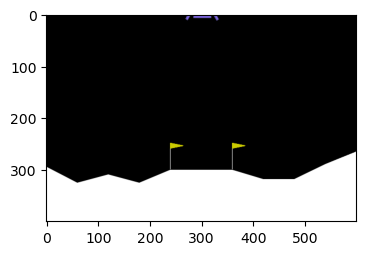

In [46]:
env.reset()
plt.imshow(env.render())

### The Observation Space

The state is an 8-dimensional vector:
- the coordinates of the lander in x & y, 
- its linear velocities in x & y, 
- its angle, 
- its angular velocity, and
- two booleans that represent whether each leg is in contact with the ground or not.

In [47]:
obs, _ = env.reset()
obs

array([ 0.00656691,  1.4087325 ,  0.6651418 , -0.09724461, -0.00760264,
       -0.1506646 ,  0.        ,  0.        ], dtype=float32)

In [48]:
list(env.observation_space.low)

[-1.5, -1.5, -5.0, -5.0, -3.1415927, -5.0, -0.0, -0.0]

In [49]:
list(env.observation_space.high)

[1.5, 1.5, 5.0, 5.0, 3.1415927, 5.0, 1.0, 1.0]

Here, you can see the low array and the high array in list form for both measurements respectively.

### The Action Space

There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

|Number|Action|
|:-|:-|
|0|Nothing|
|1|Left fire|
|2|Main fire|
|3|Right fire|

In [50]:
env.action_space

Discrete(4)

### The Reward Structure

Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

### Episode End

The episode finishes if:

- the lander crashes (the lander body gets in contact with the moon);
- the lander gets outside of the viewport (x coordinate is greater than 1);
- the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:

### Letting a random agent play

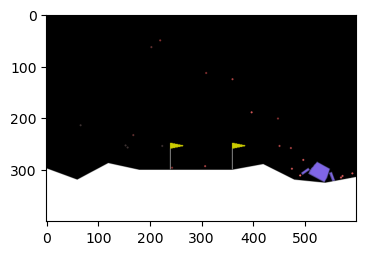

Episode reward: -191.12 | Terminated: True | Truncated: False


In [51]:
def render_env():
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    print(f"Episode reward: {total_reward:.2f} | Terminated: {terminated} | Truncated: {truncated}")

for _ in range(1):
    obs, _ = env.reset()
    total_reward = 0.0
    step_no = 0

    while True:
        step_no += 1
        reward = None

        action = env.action_space.sample()
        new_obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if step_no % 6 == 0:
            render_env()

        if terminated or truncated:
            render_env()
            break

### The DQN Model

<img src="Images/Difference Table and NN.png" width=500>

The output of the model is Q-values for every action available in the environment, without nonlinearity applied (as Q-values can have any value). The approach of having all Q-values calculated with one pass through the network helps us to increase speed significantly in comparison to treating $Q(s,a)$ literally and feeding observations and actions to the network to obtain the value of the action

In [52]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.layers(x)

### The Agent

In [53]:
# Defining hyperparameters:
DEFAULT_ENV_NAME = "LunarLander-v2"
MEAN_REWARD_BOUND = 200 # when to stop training

GAMMA = 0.99 # Discount factor for value of future state
TAU = 0.01
LEARNING_RATE = 0.0005 # Learning rate for NN
REPLAY_SIZE = 10_000 # Buffer size (memory)
# breaks the correlation between episodes
BATCH_SIZE = 32 # Batch size sampled from replay buffer
REPLAY_START_SIZE = BATCH_SIZE # How long to wait before training from buffer
UPDATE_EVERY = 4 # Interval to transfer weights to target network (in episodes)

EPSILON_START = 1.0 # Only random actions at beginning
EPSILON_FINAL = 0.02 # Fraction of random actions at end
DECAY_EPISODES =  2_000 # Over how many episodes to decay epsilon
EPSILON_DECAY = (EPSILON_START - EPSILON_FINAL) / DECAY_EPISODES

device = "cpu"

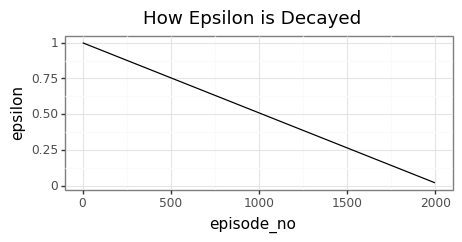

<ggplot: (151615743130)>

In [54]:
(
    ggplot(data=(pd.DataFrame({'episode_no': np.arange(1, 2000)})
                 .assign(epsilon=lambda x: x.episode_no.apply(lambda i: max(EPSILON_FINAL, EPSILON_START - i*EPSILON_DECAY)))
                 ),
           mapping=aes(x='episode_no', y='epsilon')) +
    geom_line() +
    labs(title='How Epsilon is Decayed') +
    theme_bw() +
    theme(figure_size=[5,2])
)

In [55]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action',
                                                               'reward', 'terminated', 
                                                               'truncated', 'new_state'])

class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, terminateds, truncateds, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), \
               np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(terminateds, dtype=bool), \
               np.array(truncateds, dtype=bool), \
               np.array(next_states)


The asterisk operator in the list comprehension in combination with the zip() packs the contents of the defaultdict in tuples, so we can get all the necessary information from the batch. See below:

In [56]:
list = [
  Experience(state=0, action=1, reward=0.5, terminated=False, truncated=False, new_state=2),
  Experience(state=1, action=0, reward=-0.5, terminated=True, truncated=True, new_state=3),
  Experience(state=2, action=1, reward=1.0, terminated=False, truncated=False, new_state=4)
]
list

[Experience(state=0, action=1, reward=0.5, terminated=False, truncated=False, new_state=2),
 Experience(state=1, action=0, reward=-0.5, terminated=True, truncated=True, new_state=3),
 Experience(state=2, action=1, reward=1.0, terminated=False, truncated=False, new_state=4)]

In [61]:
# Get all the information from the batch in tuples
states, actions, rewards, terminateds, truncateds, next_states = zip(*list)

# Convert the data types of the information from the batch
print(np.array(states))
print(np.array(actions))
print(np.array(rewards, dtype=np.float32))
print(np.array(terminateds, dtype=bool))
print(np.array(truncateds, dtype=bool))
print(np.array(next_states))

[0 1 2]
[1 0 1]
[ 0.5 -0.5  1. ]
[False  True False]
[False  True False]
[2 3 4]


Returning the reward at the end of an episode is not suitable anymore for Mountain Car, as -1 is incurred for each time step that is outside of the goal area. Therefore, I need to return both the reward for each time step and at the end of an episode, to
1. train the policy network
2. monitor the average reward for the stopping criterion

In [ ]:
class Agent():
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        step_reward = 0.0
        done_reward = None
        
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in env
        new_state, step_reward, is_done, is_truncated, _ = self.env.step(action)
        self.total_reward += step_reward
        
        # Push experience buffer
        exp = Experience(self.state, action, step_reward, is_done, is_truncated, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        
        if is_done or is_truncated:
            done_reward = self.total_reward
            self._reset()
        return step_reward, done_reward

In [15]:
def calc_loss(batch, net, tgt_net, device="cpu"):
    # get memory from batch (sampled from buffer)
    states, actions, rewards, terminateds, truncateds, next_states = batch
    # convert all values to tensors for PyTorch
    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    terminated_mask = torch.BoolTensor(terminateds).to(device)
    truncateds_mask = torch.BoolTensor(truncateds).to(device)

    # Get predictions of the policy network given past observed states
    # needed to fix dtype issue
    state_action_values = (net(states_v)
                           .gather(1, actions_v.unsqueeze(-1).to(dtype=torch.int64))
                           .squeeze(-1))
    # Use target network for next steps (historical)
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[terminated_mask] = 0.0
    next_state_values[truncateds_mask] = 0.0
    next_state_values = next_state_values.detach() # prevent gradients from
    # flowing into target network's graph
    # Calculate the target values for updating the policy network as:
    # reward received (immediate) and discounted max Q-Value of next state
    expected_state_action_values = rewards_v + GAMMA * next_state_values
    return nn.MSELoss()(state_action_values, expected_state_action_values)

The reason for using a separate target network to make predictions for the values of the next state is to improve the stability and convergence of the DQN algorithm.

The DQN algorithm is trained using a batch of transitions sampled from the replay buffer, where each transition consists of a state, an action, a reward, and the next state. In each iteration of the training loop, the policy network is used to make predictions for the current state and the target network is used to make predictions for the next state.

The policy network is used to make predictions on the already observed states because it is the network that is being trained to approximate the optimal Q-function. By minimizing the difference between the predicted Q-values and the target Q-values, the policy network learns to improve its predictions for future actions.

However, if we were to use the same network to make predictions for the values of the next state, it can result in instability in the learning process. This is because the policy network is constantly changing as it is being trained, and the predicted Q-values for the next state can also change rapidly with each update.

Using a separate target network to make predictions for the values of the next state helps to stabilize the learning process by providing a fixed set of predictions for the next state that can be used as targets for training the policy network. The target network is updated less frequently than the policy network, typically after a fixed number of iterations, which helps to maintain a stable set of predictions over time.

In the given code, the policy network (net) is used to make predictions for the current state, and the target network (tgt_net) is used to make predictions for the next state.

### Training the Agent

In [17]:
env = gym.make(DEFAULT_ENV_NAME, render_mode='rgb_array')
net = DQN(input_shape=env.observation_space.shape[0],
          n_actions=env.action_space.n).to(device)
tgt_net = DQN(input_shape=env.observation_space.shape[0],
              n_actions=env.action_space.n).to(device)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
iter_no = 0
 
best_mean_reward = None

while True:
    iter_no += 1
    reward, episode_reward = agent.play_step(net, epsilon, device=device)
    
    # At the end of every episode
    if episode_reward is not None:
        total_rewards.append(episode_reward)
        episode_no = len(total_rewards)
        epsilon = max(EPSILON_FINAL, EPSILON_START - episode_no*EPSILON_DECAY)
        mean_reward = np.mean(total_rewards[-100:])

        if episode_no % 100 == 0:
            print(f"Episode {episode_no} Step {iter_no:}: Mean Reward: {mean_reward:.2f} Epsilon: {epsilon:.4f}")

        # if it's the first step or if best reward improved:
        if best_mean_reward is None or best_mean_reward < mean_reward:
            if best_mean_reward is not None:
                print(f"Step {iter_no}, Episode {episode_no}: Best mean reward updated: {best_mean_reward} -> {mean_reward}")
                best_mean_reward = mean_reward

        # if reward bound is high enough to be considered solved
        if mean_reward > MEAN_REWARD_BOUND:
            print(f"Solved in {iter_no} iterations!")
            break

    # If not enough observations in buffer, then don't
    # start training the policy net yet
    if len(buffer) < REPLAY_START_SIZE:
        continue

    # every N TIME steps, adjust target net weights
    if iter_no % UPDATE_EVERY == 0:
        # tgt_net.load_state_dict(net.state_dict())
        # try soft update instead (weighted average of policy and target network (preserves most of target)):
        for target_param, policy_param in zip(tgt_net.parameters(), net.parameters()):
            target_param.data.copy_(
                TAU * policy_param.data + (1.0 - TAU) * target_param.data)

    # train the policy network (every step)
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()

Episode 100 Step 8717: Mean Reward: -154.60 Epsilon: 0.9510
Episode 200 Step 17998: Mean Reward: -135.03 Epsilon: 0.9020
Episode 300 Step 27659: Mean Reward: -120.12 Epsilon: 0.8530
Episode 400 Step 37140: Mean Reward: -104.32 Epsilon: 0.8040
Episode 500 Step 46938: Mean Reward: -101.91 Epsilon: 0.7550
Episode 600 Step 57353: Mean Reward: -86.56 Epsilon: 0.7060
Episode 700 Step 67967: Mean Reward: -81.46 Epsilon: 0.6570
Episode 800 Step 80322: Mean Reward: -62.37 Epsilon: 0.6080
Episode 900 Step 95081: Mean Reward: -49.39 Epsilon: 0.5590
Episode 1000 Step 110639: Mean Reward: -36.21 Epsilon: 0.5100
Episode 1100 Step 129751: Mean Reward: -26.93 Epsilon: 0.4610
Episode 1200 Step 158147: Mean Reward: -3.14 Epsilon: 0.4120
Episode 1300 Step 197310: Mean Reward: 16.93 Epsilon: 0.3630
Episode 1400 Step 245426: Mean Reward: 18.39 Epsilon: 0.3140
Episode 1500 Step 303365: Mean Reward: 34.20 Epsilon: 0.2650
Episode 1600 Step 362013: Mean Reward: 122.14 Epsilon: 0.2160
Episode 1700 Step 421829: 

In case the training loop output gets overwritten (took about 40 minutes):

<img src='Images/Training Process.png' width=500>

At first, the learning rate was too high (shown by erratic movement of average reward) and the batch size too big. Lowering the learning rate helped stabilise the training a little more and lowering the batch size helped speed up training. Of course, both are a tradeoff. Alternative options could have been:

- decreasing complexity of the neural networks
- decreasing TAU (soft update from policy to target network)

c:\Users\STEIM\AppData\Local\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 99 rows containing missing values.


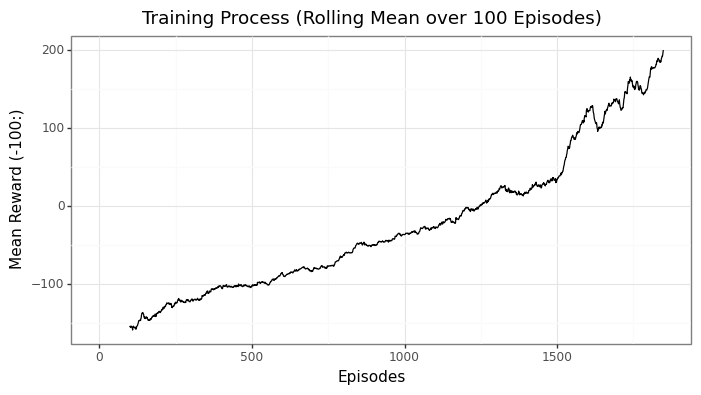

<ggplot: (104399536843)>

In [18]:
(
    ggplot(data=(pd.DataFrame({'Episodes': np.arange(1, episode_no + 1),
                               'Rewards': total_rewards})
                 .assign(Rewards=lambda x: x['Rewards'].rolling(100).mean())),
           mapping=aes(x='Episodes', y='Rewards')) +
    geom_line() +
    labs(title='Training Process (Rolling Mean over 100 Episodes)',
         y='Mean Reward (-100:)') +
    theme_bw() +
    theme(figure_size=[8, 4])
)


### Saving the Models

In [20]:
torch.save(net.state_dict(), f='policy_net.pt')
torch.save(tgt_net.state_dict(), f='target_net.pt')

### Letting the Trained Agent Play

In [16]:
# Defining the environment
device = "cpu"
env = gym.make('LunarLander-v2', render_mode='rgb_array')
obs_size = env.observation_space.shape[0] # define sizes for NN
n_actions = env.action_space.n

# Loading the model
net = DQN(obs_size, n_actions) # instance of model
net.load_state_dict(torch.load("policy_net.pt"))
net.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [17]:
def play_game(env, net, num_episodes):
    for episode in range(num_episodes):
        state, _ = env.reset()
        iter_no = 0
        epsilon = 0.0
        total_reward = 0.0
        
        while True:
            iter_no += 1
        
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_a = np.array([state], copy=False)
                state_v = torch.tensor(state_a).to(device)
                q_vals_v = net(state_v)
                _, act_v = torch.max(q_vals_v, dim=1)
                action = int(act_v.item())

            # do step in env
            new_state, step_reward, is_done, is_truncated, _ = env.step(action)
            total_reward += step_reward
            state = new_state

            if iter_no % 5 == 0:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
                
            if is_done or is_truncated:
                print(f"Reward: {total_reward:.2f}")
                state, _ = env.reset()
                break

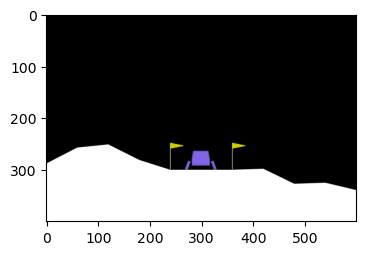

Reward: 281.45


In [18]:
# call the animation function
play_game(env, net, 1)

It sure can land, but doesn't always land in between the flags. I should maybe continue training a little longer.

### Train the Agent even longer

In [75]:
device = "cpu"

# Loading the models
net = DQN(obs_size, n_actions) # instance of model
tgt_net = DQN(obs_size, n_actions)

net.load_state_dict(torch.load("policy_net.pt"))
tgt_net.load_state_dict(torch.load("target_net.pt"))

net.train()
tgt_net.train()

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
EPSILON_DECAY = 0.995
epsilon = 0.15

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
iter_no = 0
 
best_mean_reward = None

while True:
    iter_no += 1
    reward, episode_reward = agent.play_step(net, epsilon, device=device)
    
    # At the end of every episode
    if episode_reward is not None:
        total_rewards.append(episode_reward)
        episode_no = len(total_rewards)
        epsilon = max(EPSILON_FINAL, epsilon * EPSILON_DECAY)
        mean_reward = np.mean(total_rewards[-100:])

        if episode_no % 100 == 0:
            print(f"Episode {episode_no} Step {iter_no:}: Mean Reward: {mean_reward:.2f} Epsilon: {epsilon:.4f}")

        # if it's the first step or if best reward improved:
        if best_mean_reward is None or best_mean_reward < mean_reward:
            if best_mean_reward is not None:
                print(f"Step {iter_no}, Episode {episode_no}: Best mean reward updated: {best_mean_reward} -> {mean_reward}")
                best_mean_reward = mean_reward

        # if reward bound is high enough to be considered solved
        if mean_reward >= 250:
            print(f"Solved in {iter_no} iterations!")
            break

    # If not enough observations in buffer, then don't
    # start training the policy net yet
    if len(buffer) < REPLAY_START_SIZE:
        continue

    # every N TIME steps, adjust target net weights
    if iter_no % UPDATE_EVERY == 0:
        # tgt_net.load_state_dict(net.state_dict())
        # try soft update instead (weighted average of policy and target network (preserves most of target)):
        for target_param, policy_param in zip(tgt_net.parameters(), net.parameters()):
            target_param.data.copy_(
                TAU * policy_param.data + (1.0 - TAU) * target_param.data)

    # train the policy network (every step)
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()

Episode 100 Step 45045: Mean Reward: 143.96 Epsilon: 0.0909
Episode 200 Step 81320: Mean Reward: 206.73 Epsilon: 0.0550
Episode 300 Step 114074: Mean Reward: 229.52 Epsilon: 0.0333
Episode 400 Step 142943: Mean Reward: 202.57 Epsilon: 0.0202
Episode 500 Step 186781: Mean Reward: 163.30 Epsilon: 0.0200
Episode 600 Step 215728: Mean Reward: 189.75 Epsilon: 0.0200
Episode 700 Step 248103: Mean Reward: 184.89 Epsilon: 0.0200
Episode 800 Step 277590: Mean Reward: 238.19 Epsilon: 0.0200
Solved in 304003 iterations!


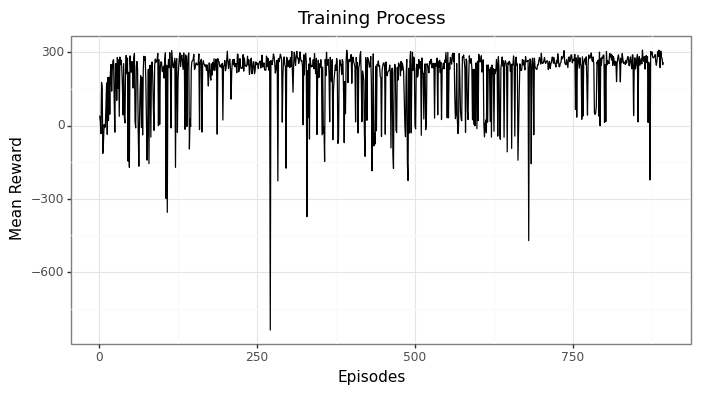

<ggplot: (104405771703)>

In [114]:
(
    ggplot(data=(pd.DataFrame({'Episodes': np.arange(1, episode_no + 1),
                               'Rewards': total_rewards})
                 .assign(Rewards=lambda x: x['Rewards'].rolling(1).mean())),
           mapping=aes(x='Episodes', y='Rewards')) +
    geom_line() +
    labs(title='Training Process',
         y='Mean Reward') +
    theme_bw() +
    theme(figure_size=[8, 4])
)


In [85]:
torch.save(net.state_dict(), f='policy_net_trained_more.pt')
torch.save(tgt_net.state_dict(), f='target_net_trained_more.pt')

### Letting the Longer Trained Agent Play

In [20]:
# Defining the environment
device = 'cpu'
env = gym.make('LunarLander-v2', render_mode='rgb_array')
obs_size = env.observation_space.shape[0] # define sizes for NN
n_actions = env.action_space.n

# Loading the model
net = DQN(obs_size, n_actions) # instance of model
net.load_state_dict(torch.load("policy_net_trained_more.pt"))
net.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

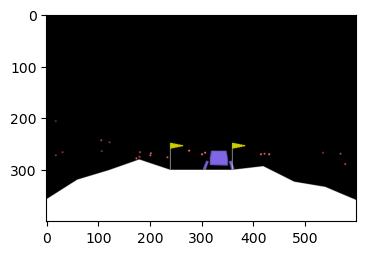

Reward: 137.55


In [21]:
# call the animation function
play_game(env, net, 1)

It seems that the agent that was trained a little longer does indeed do a better job. Begs the question: How long should you train?

### Different Soft Update Schedule

Try updating every step (soft update) instead of every couple of episodes (soft update)

In [48]:
# Defining hyperparameters:
DEFAULT_ENV_NAME = "LunarLander-v2"
MEAN_REWARD_BOUND = 200 # when to stop training

GAMMA = 0.99 # Discount factor for value of future state
TAU = 0.01 # soft update parameter
LEARNING_RATE = 0.0005 # Learning rate for NN
REPLAY_SIZE = 10_000 # Buffer size (memory)
# breaks the correlation between episodes
BATCH_SIZE = 32 # Batch size sampled from replay buffer
REPLAY_START_SIZE = BATCH_SIZE # How long to wait before training from buffer
UPDATE_EVERY = 1 # Interval to transfer weights to target network (in episodes)

EPSILON_START = 1.0 # Only random actions at beginning
EPSILON_FINAL = 0.02 # Fraction of random actions at end
DECAY_EPISODES =  2_000 # Over how many episodes to decay epsilon
EPSILON_DECAY = (EPSILON_START - EPSILON_FINAL) / DECAY_EPISODES

device = "cpu"

In [50]:
env = gym.make(DEFAULT_ENV_NAME, render_mode='rgb_array')
net = DQN(input_shape=env.observation_space.shape[0],
          n_actions=env.action_space.n).to(device)
tgt_net = DQN(input_shape=env.observation_space.shape[0],
              n_actions=env.action_space.n).to(device)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
iter_no = 0
 
best_mean_reward = None

while True:
    iter_no += 1
    reward, episode_reward = agent.play_step(net, epsilon, device=device)
    
    # At the end of every episode
    if episode_reward is not None:
        total_rewards.append(episode_reward)
        episode_no = len(total_rewards)
        epsilon = max(EPSILON_FINAL, EPSILON_START - episode_no*EPSILON_DECAY)
        mean_reward = np.mean(total_rewards[-100:])

        if episode_no % 100 == 0:
            print(f"Episode {episode_no} Step {iter_no:}: Mean Reward: {mean_reward:.2f} Epsilon: {epsilon:.4f}")

        # if it's the first step or if best reward improved:
        if best_mean_reward is None or best_mean_reward < mean_reward:
            if best_mean_reward is not None:
                print(f"Step {iter_no}, Episode {episode_no}: Best mean reward updated: {best_mean_reward} -> {mean_reward}")
                best_mean_reward = mean_reward

        # if reward bound is high enough to be considered solved
        if mean_reward > MEAN_REWARD_BOUND:
            print(f"Solved in {iter_no} iterations!")
            break

    # If not enough observations in buffer, then don't
    # start training the policy net yet
    if len(buffer) < REPLAY_START_SIZE:
        continue

    # every N TIME steps, adjust target net weights
    if iter_no % UPDATE_EVERY == 0:
        # tgt_net.load_state_dict(net.state_dict())
        # try soft update instead (weighted average of policy and target network (preserves most of target)):
        for target_param, policy_param in zip(tgt_net.parameters(), net.parameters()):
            target_param.data.copy_(
                TAU * policy_param.data + (1.0 - TAU) * target_param.data)

    # train the policy network (every step)
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()

Episode 100 Step 9296: Mean Reward: -169.66 Epsilon: 0.9510
Episode 200 Step 18606: Mean Reward: -142.78 Epsilon: 0.9020
Episode 300 Step 29078: Mean Reward: -125.29 Epsilon: 0.8530
Episode 400 Step 38705: Mean Reward: -105.15 Epsilon: 0.8040
Episode 500 Step 48502: Mean Reward: -88.65 Epsilon: 0.7550
Episode 600 Step 60235: Mean Reward: -78.72 Epsilon: 0.7060
Episode 700 Step 71830: Mean Reward: -70.58 Epsilon: 0.6570
Episode 800 Step 84152: Mean Reward: -54.36 Epsilon: 0.6080
Episode 900 Step 98518: Mean Reward: -46.26 Epsilon: 0.5590
Episode 1000 Step 112192: Mean Reward: -38.55 Epsilon: 0.5100
Episode 1100 Step 127925: Mean Reward: -23.88 Epsilon: 0.4610
Episode 1200 Step 156872: Mean Reward: -20.54 Epsilon: 0.4120
Episode 1300 Step 197178: Mean Reward: -10.49 Epsilon: 0.3630
Episode 1400 Step 254739: Mean Reward: 8.06 Epsilon: 0.3140
Episode 1500 Step 303105: Mean Reward: 8.49 Epsilon: 0.2650
Episode 1600 Step 364973: Mean Reward: 66.73 Epsilon: 0.2160
Episode 1700 Step 423186: Me

In [52]:
episode_no

1983

c:\Users\STEIM\AppData\Local\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 99 rows containing missing values.


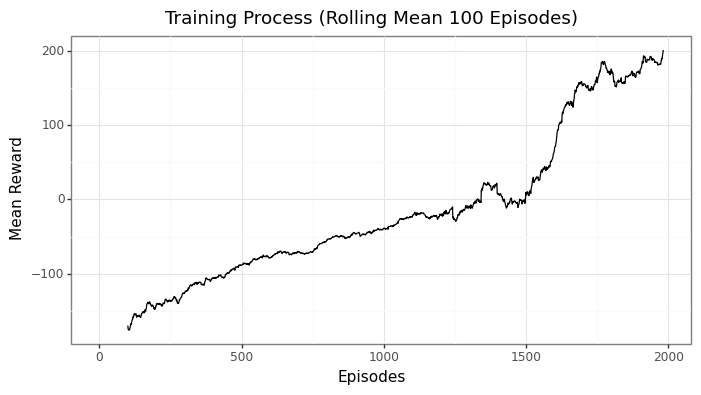

<ggplot: (157016926926)>

In [65]:
(
    ggplot(data=(pd.DataFrame({'Episodes': np.arange(1, episode_no + 1),
                               'Rewards': total_rewards})
                 .assign(Rewards=lambda x: x['Rewards'].rolling(100).mean())),
           mapping=aes(x='Episodes', y='Rewards')) +
    geom_line() +
    labs(title='Training Process (Rolling Mean 100 Episodes)',
         y='Mean Reward') +
    theme_bw() +
    theme(figure_size=[8, 4])
)


Training seems to be slightly more well behaved with the soft updates every step but keeping TAU low.

Could also try an exponential epsilon decay instead of linear, but not necessary anymore.

### Custom Terrain?

### RayTune?